https://www.researchgate.net/publication/360698153_A_Tutorial_on_Structural_Optimization 

In [1]:
import time
import numpy as np                                                # for dense matrix ops
import matplotlib.pyplot as plt                                   # for plotting
import autograd, autograd.core, autograd.extend, autograd.tracer  # for adjoints
import autograd.numpy as anp      
import scipy, scipy.ndimage, scipy.sparse, scipy.sparse.linalg    # sparse matrices

import nlopt                                                      # for optimization

# FEM Model

In [2]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
    
def get_args(normals, forces, density=0.4):  # Manage the problem setup parameters
    width = normals.shape[0] - 1
    height = normals.shape[1] - 1
    fixdofs = np.flatnonzero(normals.ravel())
    alldofs = np.arange(2 * (width + 1) * (height + 1))
    freedofs = np.sort(list(set(alldofs) - set(fixdofs)))
    params = {
          # material properties
          'young': 1, 'young_min': 1e-9, 'poisson': 0.3, 'g': 0,
          # constraints
          'density': density, 'xmin': 0.001, 'xmax': 1.0,
          # input parameters
          'nelx': width, 'nely': height, 'mask': 1, 'penal': 3.0, 'filter_width': 1,
          'freedofs': freedofs, 'fixdofs': fixdofs, 'forces': forces.ravel(),
          # optimization parameters
          'opt_steps': 80, 'print_every': 10}
    return ObjectView(params)

def mbb_beam(width=6, height=6, density=0.4, y=1, x=0):  # textbook beam example
    normals = np.zeros((width + 1, height + 1, 2))
    normals[-1, -1, y] = 1
    normals[0, :, x] = 1
    forces = np.zeros((width + 1, height + 1, 2))
    forces[0, 0, y] = -1
    return normals, forces, density

In [3]:
def young_modulus(x, e_0, e_min, p=3):
    return e_min + x ** p * (e_0 - e_min)

def physical_density(x, args, volume_contraint=False, use_filter=True):
    x = args.mask * x.reshape(args.nely, args.nelx)  # reshape from 1D to 2D
    return gaussian_filter(x, args.filter_width) if use_filter else x  # maybe filter

def mean_density(x, args, volume_contraint=False, use_filter=True):
    return anp.mean(physical_density(x, args, volume_contraint, use_filter)) / anp.mean(args.mask)

In [4]:
def objective(x, args, volume_contraint=False, use_filter=True):
    kwargs = dict(penal=args.penal, e_min=args.young_min, e_0=args.young)
    x_phys = physical_density(x, args, volume_contraint=volume_contraint, use_filter=use_filter)
    ke     = get_stiffness_matrix(args.young, args.poisson)  # stiffness matrix
    u      = displace(x_phys, ke, args.forces, args.freedofs, args.fixdofs, **kwargs)
    c      = compliance(x_phys, u, ke, **kwargs)
    return c

In [5]:
@autograd.extend.primitive
def gaussian_filter(x, width): # 2D gaussian blur/filter
    return scipy.ndimage.gaussian_filter(x, width, mode='reflect')

def _gaussian_filter_vjp(ans, x, width): # gives the gradient of orig. function w.r.t. x
    del ans, x  # unused
    return lambda g: gaussian_filter(g, width)
autograd.extend.defvjp(gaussian_filter, _gaussian_filter_vjp)

In [6]:
def compliance(x_phys, u, ke, *, penal=3, e_min=1e-9, e_0=1):
    nely, nelx = x_phys.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords for the index map

    n1 = (nely+1)*(elx+0) + (ely+0)  # nodes
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    all_ixs = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    u_selected = u[all_ixs]  # select from u matrix

    ke_u = anp.einsum('ij,jkl->ikl', ke, u_selected)  # compute x^penal * U.T @ ke @ U
    ce = anp.einsum('ijk,ijk->jk', u_selected, ke_u)
    C = young_modulus(x_phys, e_0, e_min, p=penal) * ce.T
    return anp.sum(C)

def get_stiffness_matrix(e, nu):  # e=young's modulus, nu=poisson coefficient
    k = anp.array([1/2-nu/6, 1/8+nu/8, -1/4-nu/12, -1/8+3*nu/8,
                -1/4+nu/12, -1/8-nu/8, nu/6, 1/8-3*nu/8])
    return e/(1-nu**2)*anp.array([[k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
                               [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
                               [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
                               [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
                               [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
                               [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
                               [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
                               [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]])

In [7]:
def get_k(stiffness, ke):
    # Constructs sparse stiffness matrix k (used in the displace fn)
    # First, get position of the nodes of each element in the stiffness matrix
    nely, nelx = stiffness.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords
    ely, elx = ely.reshape(-1, 1), elx.reshape(-1, 1)

    n1 = (nely+1)*(elx+0) + (ely+0)
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    edof = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    edof = edof.T[0]
    x_list = anp.repeat(edof, 8)  # flat list pointer of each node in an element
    y_list = anp.tile(edof, 8).flatten()  # flat list pointer of each node in elem

    # make the global stiffness matrix K
    kd = stiffness.T.reshape(nelx*nely, 1, 1)
    value_list = (kd * anp.tile(ke, kd.shape)).flatten()
    return value_list, y_list, x_list

def displace(x_phys, ke, forces, freedofs, fixdofs, *, penal=3, e_min=1e-9, e_0=1):
    # Displaces the load x using finite element techniques (solve_coo=most of runtime)
    stiffness = young_modulus(x_phys, e_0, e_min, p=penal)
    k_entries, k_ylist, k_xlist = get_k(stiffness, ke)

    index_map, keep, indices = _get_dof_indices(freedofs, fixdofs, k_ylist, k_xlist)

    u_nonzero = solve_coo(k_entries[keep], indices, forces[freedofs], sym_pos=True)
    u_values = anp.concatenate([u_nonzero, anp.zeros(len(fixdofs))])
    return u_values[index_map]

In [8]:
def _get_dof_indices(freedofs, fixdofs, k_xlist, k_ylist):
    index_map = inverse_permutation(anp.concatenate([freedofs, fixdofs]))
    keep = anp.isin(k_xlist, freedofs) & anp.isin(k_ylist, freedofs)
    # Now we index an indexing array that is being indexed by the indices of k
    i = index_map[k_ylist][keep]
    j = index_map[k_xlist][keep]
    return index_map, keep, anp.stack([i, j])

def inverse_permutation(indices):  # reverses an index operation
    inverse_perm = np.zeros(len(indices), dtype=anp.int64)
    inverse_perm[indices] = np.arange(len(indices), dtype=anp.int64)
    return inverse_perm

In [9]:
def _get_solver(a_entries, a_indices, size, sym_pos):
    # a is (usu.) symmetric positive; could solve 2x faster w/sksparse.cholmod.cholesky(a).solve_A
    a = scipy.sparse.coo_matrix((a_entries, a_indices), shape=(size,)*2).tocsc()
    return scipy.sparse.linalg.splu(a).solve

@autograd.primitive
def solve_coo(a_entries, a_indices, b, sym_pos=False):
    solver = _get_solver(a_entries, a_indices, b.size, sym_pos)
    return solver(b)

def grad_solve_coo_entries(ans, a_entries, a_indices, b, sym_pos=False):
    def jvp(grad_ans):
        lambda_ = solve_coo(a_entries, a_indices if sym_pos else a_indices[::-1],
                            grad_ans, sym_pos)
        i, j = a_indices
        return -lambda_[i] * ans[j]
    return jvp

autograd.extend.defvjp(solve_coo, grad_solve_coo_entries,
                       lambda: print('err: gradient undefined'),
                       lambda: print('err: gradient not implemented'))

# Optimization

In [10]:
def fast_stopt(args, x=None, verbose=True):
    if x is None:
        x = anp.ones((args.nely, args.nelx)) * args.density  # init mass

    reshape = lambda x: x.reshape(args.nely, args.nelx)
    objective_fn = lambda x: objective(reshape(x), args) # don't enforce mass constraint here
    constraint = lambda params: mean_density(reshape(params), args) - args.density
   

    def wrap_autograd_func(func, losses=None, frames=None):
        def wrapper(x, grad):
            if grad.size > 0:
                value, grad[:] = autograd.value_and_grad(func)(x)
            else:
                value = func(x)
            if losses is not None:
                losses.append(value)
            if frames is not None:
                frames.append(reshape(x).copy())
                if verbose and len(frames) % args.print_every == 0:
                    print('step {}, loss {:.2e}, t={:.2f}s'.format(len(frames), value, time.time()-dt))
            return value
        return wrapper

    losses, frames = [], [] ; dt = time.time()
    print('Optimizing a problem with {} nodes'.format(len(args.forces)))
    opt = nlopt.opt(nlopt.LD_MMA, x.size)
    opt.set_lower_bounds(0.0) ; opt.set_upper_bounds(1.0)
    opt.set_min_objective(wrap_autograd_func(objective_fn, losses, frames))
    opt.add_inequality_constraint(wrap_autograd_func(constraint), 1e-8)
    opt.set_maxeval(args.opt_steps + 1)
    opt.optimize(x.flatten())
    
    return np.array(losses), reshape(frames[-1]), np.array(frames),objective_fn

Optimizing a problem with 98 nodes
step 10, loss 1.09e+02, t=0.02s
step 20, loss 8.51e+01, t=0.04s
step 30, loss 8.23e+01, t=0.05s
step 40, loss 8.23e+01, t=0.07s
step 50, loss 8.22e+01, t=0.09s
step 60, loss 8.22e+01, t=0.10s
step 70, loss 8.22e+01, t=0.12s
step 80, loss 8.22e+01, t=0.13s

Best fit:  82.2464604342973

Final design space:


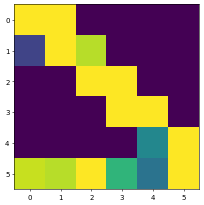


Final MBB beam design:


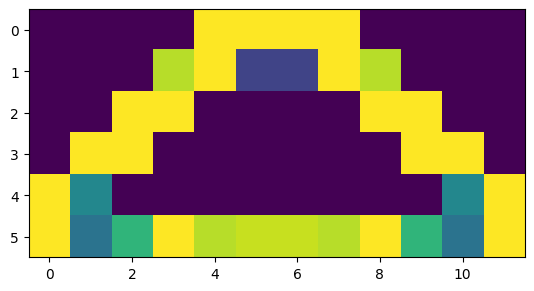

In [11]:
# run the simulation and visualize the result
args = get_args(*mbb_beam())
losses, x, mbb_frames, fun = fast_stopt(args=args, verbose=True)
print()
print('Best fit: ', fun(x))

plt.figure(dpi=50) ; print('\nFinal design space:')
plt.imshow(x) ; plt.show()
plt.figure(dpi=100) ; print('\nFinal MBB beam design:')
plt.imshow(np.concatenate([x[:,::-1],x], axis=1)) ; plt.show()